In [8]:
import numpy as np
from splinv import detect
from splinv import hmod
from splinv import darkmapper
from splinv.grid import Cartesian
from configparser import ConfigParser
import splinv
import time
import matplotlib.pyplot as plt

Check if halo itself accounts for difference in different length scale in redshifts. 

In [3]:
""" Test sparse reconstruction of weak lensing dark map
"""
# configuration
configName  =   'numerical_frames.ini'
parser      =   ConfigParser()
parser.read(configName)

# halo simulation
# z_h1     =  0.3325
# z_h2     =  0.5
# log_m1   =  14.9
# log_m2   =  14.9
# M_200_1   =  10.**(log_m1)
# M_200_2  = 10.**(log_m2)
# conc    =  4.
# halo1    =  hmod.triaxialJS02(mass=M_200_1,conc=conc,redshift=z_h1,ra=0.,dec=0,a_over_c=1,a_over_b=1, tri_nfw = False, long_truncation = True, OLS03 = True) #33,16
# halo2    =  hmod.nfwWB00(mass=M_200_1,conc=conc,redshift=z_h1,ra=0.,dec=0)

['numerical_frames.ini']

In [98]:
len(np.array([[3,4,5],[4,5,5]]))

2

In [87]:
n=100
log_m_array = np.linspace(14.6,15.1,n)
zh_array = np.linspace(0.15,0.3,n)
scale = np.zeros((n,n))
kernel = np.zeros(n)

In [88]:
conc = 4
M,Z = np.meshgrid(log_m_array,zh_array)
for i in range(n):
    for j in range(n):
        halo = hmod.triaxialJS02(mass=10**M[i,j],conc=conc,redshift=Z[i,j],ra=0.,dec=0,a_over_c=1,a_over_b=1, tri_nfw = True, long_truncation = True, OLS03 = True)
        scale[i,j] = halo.b_TNFW_over_sigma_crit(1) * halo.lensKernel(0.3)
        #kernel[i,j] = halo.lensKernel(0.5)
        
        
        
        
        
        

In [89]:
# print(M)
# M[2,3]

In [90]:
# print(Z)

We want frames to include both of these...

In [91]:
# print(kernel)

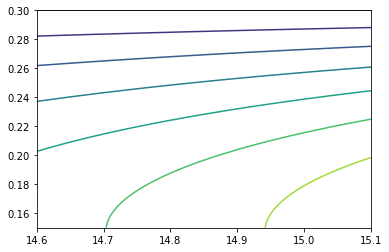

In [92]:
plt.contour(M,Z,scale)

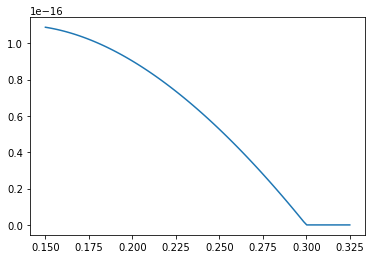

In [86]:
for i in range(n):
    halo = hmod.triaxialJS02(mass=10**14.8,conc=conc,redshift=zh_array[i],ra=0.,dec=0,a_over_c=1,a_over_b=1, tri_nfw = True, long_truncation = True, OLS03 = True)
    kernel[i]  = halo.lensKernel(0.3)
    
    
    
plt.plot(zh_array,kernel)

In [62]:



halo1 = hmod.triaxialJS02(mass=10**14.8,conc=conc,redshift=0.15,ra=0.,dec=0,a_over_c=1,a_over_b=1, tri_nfw = True, long_truncation = True, OLS03 = True)

halo2 = hmod.triaxialJS02(mass=10**14.8,conc=conc,redshift=0.19375,ra=0.,dec=0,a_over_c=1,a_over_b=1, tri_nfw = True, long_truncation = True, OLS03 = True)

print(halo1.lensKernel(1))
#print(halo1.b_TNFW_over_sigma_crit(1))
print(halo2.lensKernel(1))
#print(halo2.b_TNFW_over_sigma_crit(1))


1.838262097564675e-16
2.1156305759433346e-16


generating mock catalog this way has the freedom of moving the halo around. 

In [6]:
# Reconstruction Init
parser.set('sparse','mu','3e-4')            #step size for gradient descent
parser.set('lens','resolve_lim','0.02')     #pix
parser.set('lens','rs_base','%s' %(halo1.rs))  #Mpc/h
parser.set('sparse','nframe','1' )
# parser.set('transPlane','nx','96')
# parser.set('transPlane','ny','96')#larger stamp size
# parser.set('transPlane','xmin','-98')
# parser.set('transPlane','ymin','-98')
parser.set('transPlane','smooth_scale','1.5')
parser.set('lens','SigmaFname','SmoothOnePointFive/JS02Sigma_inf148_OLS03_1point5.fits')

# Pixelation
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False)

general_grid    =   hmod.triaxialJS02_grid_mock(parser)
# kappa1   =   general_grid.add_halo(halo1)[0]
# kappa2   =   general_grid.add_halo(halo2)[0]
#shear1, gErr0   =   general_grid.add_halo_from_dsigma(halo1, add_noise = True) #from dsigma
shear2   =   general_grid.add_halo(halo2)[1]
#sigma1   =   general_grid.add_halo(halo1)[2]
#sigma2   =   general_grid.add_halo(halo2)[2]
gErr    =   np.ones(Grid.shape)*0.05

#totalshear = shear1 + shear2 #shear1 + shear2

In [7]:
#gErr    =   np.ones(Grid.shape)*0.16

In [8]:
Grid.shape

(10, 48, 48)

In [9]:
shear2.shape

(10, 48, 48)

In [10]:
import matplotlib.pyplot as plt
# plt.imshow(sigma1)

In [11]:
s = time.time()
dmapper =   darkmapper(parser,shear2.real, shear2.imag, gErr,lensKer1)

dmapper.lbd=lbd      # Lasso penalty. was 8
dmapper.lcd=0.      # Ridge penalty in Elastic net
dmapper.nonNeg=True # using non-negative Lasso
dmapper.clean_outcomes()
dmapper.fista_gradient_descent_fast(3000) # run 3000 steps
w   =   dmapper.adaptive_lasso_weight(gamma=2.) # determine the apaptive weight
dmapper.fista_gradient_descent(3000,w=w)   
e = time.time()# run adaptive lasso
print(e-s)

preparing numerical frames!!!!
81.53122520446777


In [12]:
s = time.time()
dmapper.mu=3e-3     # step size for gradient descent
for _ in range(3):  # redo apaptive lasso, letting it run for more iteration
    w   =   dmapper.adaptive_lasso_weight(gamma=2.)
    dmapper.fista_gradient_descent_fast(3000,w=w)
dmapper.reconstruct()
e = time.time()
print(e-s)

117.2824387550354


In [13]:
Grid.zlcgrid

array([0.0625, 0.1075, 0.1525, 0.1975, 0.2425, 0.2875, 0.3325, 0.3775,
       0.4225, 0.4675])

In [14]:
c1  =   detect.local_maxima_3D(dmapper.deltaR)
print(c1)
logm_est1=   np.log10((dmapper.alphaR*dmapper._w)[6,0,24,24])+14. # first halo
#logm_est2=   np.log10((dmapper.alphaR*dmapper._w)[7,0,24,24])+14. #second halo

(array([[ 6, 24, 24]]), array([44.16496637]))


In [15]:
# first = 4
# second = 3

# print("First z interval:", str(round(Grid.zlcgrid[first], 4)))
# print("second z interval:", str(round(Grid.zlcgrid[second], 4)))

In [16]:
Grid.zlcgrid

array([0.0625, 0.1075, 0.1525, 0.1975, 0.2425, 0.2875, 0.3325, 0.3775,
       0.4225, 0.4675])

it worked i guess

In [17]:
print("mass 1:", logm_est1)
#print("mass 2:", logm_est2)
print("true mass 1:", log_m1)
print("true mass 2:", log_m2)
#when c=4, the result only agrees to unit digit

mass 1: 14.927186633886318
true mass 1: 14.9
true mass 2: 14.9


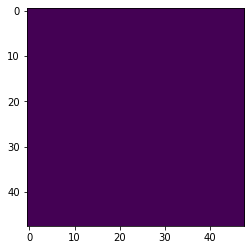

In [18]:
plt.imshow(dmapper.alphaR[5,0])

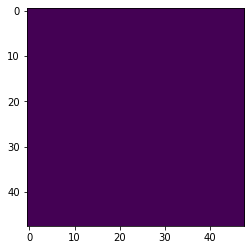

In [19]:
plt.imshow(dmapper.deltaR[5])

In [20]:
np.max(dmapper.deltaR)

5.381960140146092

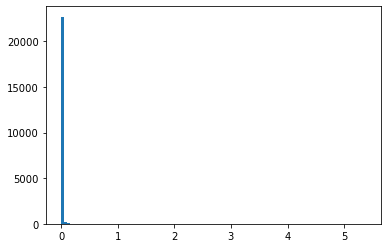

In [21]:
plt.hist(np.ravel(dmapper.deltaR),bins=100)
plt.show()

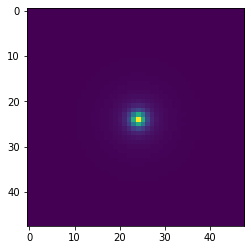

In [22]:
plt.imshow(np.fft.fftshift(np.fft.fft2(dmapper.modelDict.fouaframesInter[9,0]).real))

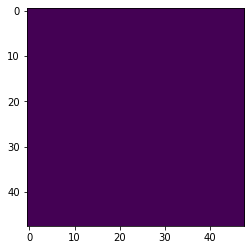

In [23]:
import matplotlib.pyplot as plt
plt.imshow(dmapper.deltaR[4])

(10, 1, 48, 48)


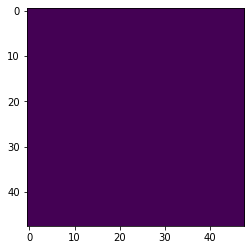

In [24]:
print(dmapper.alphaR.shape)
plt.imshow(dmapper.alphaR[5,0])

In [25]:
print(np.max(dmapper.diff))

1.0277352458020784e-09
